In [1]:
!pip install imutils
!pip install gdown

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=7ec65b7ed2badf004702f9fb3b8d8be817b6b756de3970032283846854d74434
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
    Preparing wheel metadata ... - done
  Created wheel for gdown: filename=gdown-3.13.0-py3-none-any.whl size=9034 sha256=8fc10b3e3edaa097e416d3c4ddacedbb8cf7678c6f2e0082841a8e49c1d5e156
  Stored in directory: /root/.cache/pip/wheels/2f/2a/2f/86449b6bdbaa9aef873f68332b68be6bfbc386b9219f47157d
Successfully built gdown


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import shutil
from tqdm import tqdm
import imutils
random.seed(69)

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
!ls ../input/cabani-split-3cls/split/test

correct  incorrect  no_mask


In [4]:
DATA = '../input/cabani-split-3cls/split/'
IMG_SIZE = 224 # image input size for classifier
BATCH_SIZE = 512

In [5]:
# reading splitted data
train_dataset = image_dataset_from_directory(os.path.join(DATA, 'train'),
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=(IMG_SIZE, IMG_SIZE), 
                                             label_mode='categorical')

validation_dataset = image_dataset_from_directory(os.path.join(DATA, 'val'),
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=(IMG_SIZE, IMG_SIZE), 
                                                  label_mode='categorical')

test_dataset = image_dataset_from_directory(os.path.join(DATA, 'test'), 
                                            image_size=(IMG_SIZE, IMG_SIZE), 
                                            label_mode='categorical')

Found 24475 files belonging to 3 classes.
Found 5244 files belonging to 3 classes.
Found 5247 files belonging to 3 classes.


In [6]:
# the classes will be ordered according to alphabet in image_dataset_from_directory
classes = train_dataset.class_names
classes

['correct', 'incorrect', 'no_mask']

In [7]:
# the dataset is unbalanced
for cla in sorted(os.listdir(os.path.join(DATA, 'train'))):
    print(cla, len(os.listdir(os.path.join(DATA, 'train', cla))))

correct 5719
incorrect 11756
no_mask 7000


In [8]:
# setting weight for each class
input_folder = os.path.join(DATA, 'train')

files_per_class = []
for folder in sorted(os.listdir(input_folder)):
    if not os.path.isfile(folder):
            files_per_class.append(len(os.listdir(os.path.join(input_folder, folder))))

class_weights = {}
for i in range(len(files_per_class)):
    class_weights[i] = max(files_per_class)/float(files_per_class[i])
print (class_weights)

{0: 2.0556041265955587, 1: 1.0, 2: 1.6794285714285715}


In [9]:
# prefetch data before next batch to utilise threading
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
# randomly flip the input training data horizontally or rotate them (which is done before each training epoch)
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [11]:
# creating preprocessing layer specific to mobilenet v2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [12]:
# reading mobilenet v2 weight pretrained on imagenet dataset, setting trainable to False first, will be unfreezed later to fine tune it
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3, )
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
________________

In [13]:
# creating the top layers which will replace the removed top layers of mobilenet v2
# initiating the model
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = AveragePooling2D(pool_size=(7, 7))(x)
x = Flatten(name="flatten")(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(len(classes), activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
# compiling the model with cross entropy loss and adam optimizer with 0.0001 lr
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [15]:
# doing transfer learning with base model frozen for 20 epochs
initial_epochs = 20

save_best = ModelCheckpoint('best.hdf5', save_best_only=True, monitor='val_loss', mode='min') # save the best model along training
                                                                                              # to avoid running twice

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset, 
                    callbacks=[save_best], 
                    class_weight=class_weights)

Epoch 1/20
48/48 [==============================] - 158s 3s/step - loss: 1.3474 - accuracy: 0.5460 - val_loss: 0.2975 - val_accuracy: 0.8801
Epoch 2/20
48/48 [==============================] - 89s 2s/step - loss: 0.4606 - accuracy: 0.8685 - val_loss: 0.1936 - val_accuracy: 0.9209
Epoch 3/20
48/48 [==============================] - 89s 2s/step - loss: 0.2986 - accuracy: 0.9237 - val_loss: 0.1474 - val_accuracy: 0.9449
Epoch 4/20
48/48 [==============================] - 89s 2s/step - loss: 0.2348 - accuracy: 0.9421 - val_loss: 0.1202 - val_accuracy: 0.9539
Epoch 5/20
48/48 [==============================] - 88s 2s/step - loss: 0.1917 - accuracy: 0.9539 - val_loss: 0.1009 - val_accuracy: 0.9624
Epoch 6/20
48/48 [==============================] - 89s 2s/step - loss: 0.1796 - accuracy: 0.9558 - val_loss: 0.0895 - val_accuracy: 0.9670
Epoch 7/20
48/48 [==============================] - 90s 2s/step - loss: 0.1607 - accuracy: 0.9619 - val_loss: 0.0790 - val_accuracy: 0.9723
Epoch 8/20
48/48 [=

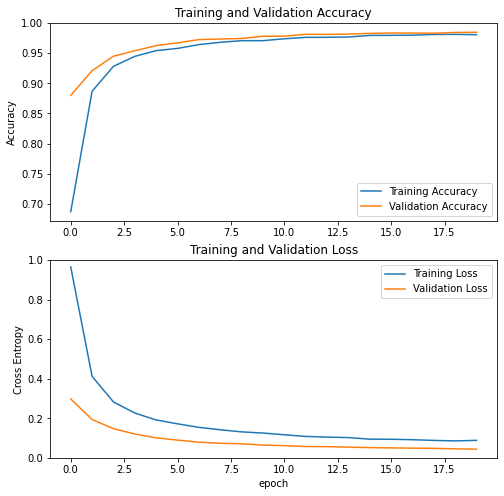

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
model = tf.keras.models.load_model('best.hdf5')
base_model = model.layers[4]
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [18]:
# unfreeze the base model to fine tune it
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

# fine tune from this layer onwards
fine_tune_at = 100

# freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

len(model.trainable_variables)

Number of layers in the base model:  154


58

In [19]:
# compile the model again to make the changes valid
# using much lower lr here to not mess up with the pretrained layer
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [20]:
# fine tuning for 10 epochs with checkpoint
fine_tune_epochs = 10

save_best_ft = ModelCheckpoint('best_ft.hdf5', save_best_only=True, monitor='val_loss', mode='min')

history_fine = model.fit(train_dataset,
                         epochs=fine_tune_epochs,
                         validation_data=validation_dataset, 
                         callbacks=[save_best_ft])

Epoch 1/10
48/48 [==============================] - 98s 2s/step - loss: 0.0689 - accuracy: 0.9776 - val_loss: 0.0329 - val_accuracy: 0.9878
Epoch 2/10
48/48 [==============================] - 92s 2s/step - loss: 0.0388 - accuracy: 0.9878 - val_loss: 0.0209 - val_accuracy: 0.9926
Epoch 3/10
48/48 [==============================] - 93s 2s/step - loss: 0.0321 - accuracy: 0.9898 - val_loss: 0.0188 - val_accuracy: 0.9931
Epoch 4/10
48/48 [==============================] - 93s 2s/step - loss: 0.0248 - accuracy: 0.9924 - val_loss: 0.0241 - val_accuracy: 0.9918
Epoch 5/10
48/48 [==============================] - 92s 2s/step - loss: 0.0256 - accuracy: 0.9917 - val_loss: 0.0157 - val_accuracy: 0.9949
Epoch 6/10
48/48 [==============================] - 92s 2s/step - loss: 0.0217 - accuracy: 0.9928 - val_loss: 0.0150 - val_accuracy: 0.9950
Epoch 7/10
48/48 [==============================] - 96s 2s/step - loss: 0.0186 - accuracy: 0.9943 - val_loss: 0.0243 - val_accuracy: 0.9920
Epoch 8/10
48/48 [==

In [21]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

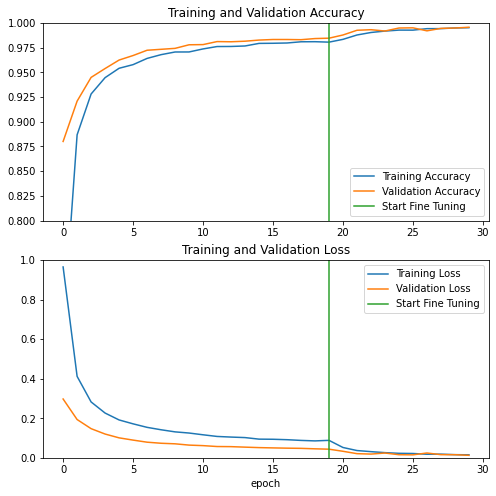

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
# infering on test dataset
model = tf.keras.models.load_model('best_ft.hdf5')

y_test = np.array([])
y_pred = np.array([])
for x, y in tqdm(test_dataset):
    y_test = np.concatenate([y_test, y.numpy().argmax(axis=1)])
    y_pred = np.concatenate([y_pred, model.predict(x).argmax(axis=1)])

100%|██████████| 164/164 [00:31<00:00,  5.15it/s]


In [24]:
# test accuracy
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

164/164 [==============================] - 15s 85ms/step - loss: 0.0121 - accuracy: 0.9960
Test accuracy : 0.9959977269172668


In [25]:
# classification report by each class
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      1227
         1.0       1.00      1.00      1.00      2520
         2.0       0.99      1.00      1.00      1500

    accuracy                           1.00      5247
   macro avg       1.00      0.99      1.00      5247
weighted avg       1.00      1.00      1.00      5247



In [26]:
# plotting confussion matrix
cm = pd.crosstab(y_test, y_pred)
cm.index = classes
cm.columns = classes
cm.columns.name = 'prediction'
cm.index.name = 'ground truth'
cm

prediction,correct,incorrect,no_mask
ground truth,,,
correct,1209,9,9
incorrect,1,2518,1
no_mask,1,0,1499


In [27]:
# model.save('tl1.model')
# loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/softcomp/tl1.model')